# Markov chain for the reliability of a single component system

## Abstract 

We simulate a Markov chain for a system made of a single component.

We use an example from (Demgne, 2015), p.47, Exemple 33. 

Considérons un système mono-composant dont la durée de vie suit la distribution exponentielle $\mathcal{E}(\lambda)$ de paramètre $\lambda > 0$, où $1 / \lambda$ est la moyenne de la distribution. 

"Le composant est supposé neuf au démarrage. Lorsque le composant est en panne, il est immédiatement remplacé par un neuf. Si on note $I_t$ l'état du composant à l'instant $t$, $X_t$ la dernière date de renouvellement du composant à l'instant $t$ alors $(I_it, X_t, t)_{t\geq 0}$ est un PDMP. Le composant étant remis en état de marche instantanément, il reste toujours dans cet état. Nous avons alors $I_t = \textrm{marche}$ pour tout $t\geq 0$.".

## Références

* Demgne, Jeanne Ady. Modélisation d’actifs industriels pour l’optimisation robuste de stratégies de maintenance. Thèse de doctorat. Pau, 2015.
* Davis, Mark HA. "Piecewise‐deterministic Markov processes: a general class of non‐diffusion stochastic models." Journal of the Royal Statistical Society: Series B (Methodological) 46.3 (1984): 353-376.
* Davis, M. H. A. (1993). Markov models and optimization. Number 49 in Monographs on statistics and applied probability. Chapman & Hall, London.

In [1]:
import openturns as ot
import otmarkov

Fonction de transition
---

Fonction qui permet d'aller de l'état courant à l'état suivant.

In [2]:
def single_component_model(X):
    """
    Simulate a single-component system.

    The inputs are:
        * X[0] : T, the life time of the component at this step
        * X[1] : cumulated_T, the cumulate life time of the component

    The output is the new state, which is the sum of the cumulated life time
    and the current life time.

    Parameters
    ----------
    X : ot.Point(1)
        The input of the model.

    Returns
    -------
    new_cumulated_T : ot.Point(1)
        The updated cumulated life time of the component.
    """
    X = ot.Point(X)
    T, cumulated_T = X
    new_cumulated_T = T + cumulated_T
    verbose = False  # Set to True to print intermediate messages.
    if verbose:
        print("X=", X, "New state=", new_state)
    return [new_cumulated_T]


model_py = ot.PythonFunction(2, 1, single_component_model)
model_py.setInputDescription(["Durée de vie", "Durée cumulée."])
model_py.setOutputDescription(["Durée cumulée."])

A l'état initial, la durée cumulée est nulle. Supposons que la durée de vie est de 8 ans. Le modèle réalise le cumul. 

In [3]:
cumulated_T = 0.0
T = 8.0
X = [T, cumulated_T]
new_state = model_py(X)
new_state

class=Point name=Unnamed dimension=1 values=[8]

Create a parametric function from the model. 
The input is random, the parameter is the state, the output is the new state.

In [4]:
initial_state = [0.0]
indices = [1]
step_function = ot.ParametricFunction(model_py, indices, initial_state)

In [5]:
cumulated_T = 0.0
step_function.setParameter([cumulated_T])
T = 8.0
X = [T]
new_state = step_function(X)
new_state

class=Point name=Unnamed dimension=1 values=[8]

## Distributions  de la durée de vie du composant

In [6]:
lambda_parameter = 0.1
dist_X = ot.Exponential(lambda_parameter)

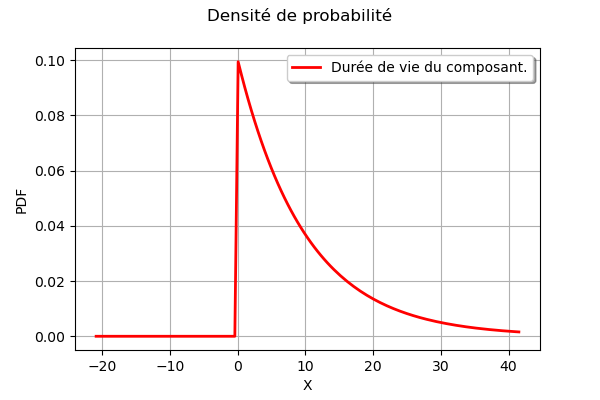

In [7]:
graph = dist_X.drawPDF()
graph.setLegends(["Durée de vie du composant."])
graph.setTitle("Densité de probabilité")
graph.setXTitle("X")
graph

We now create the random vector.

In [8]:
distribution = ot.ComposedDistribution([dist_X])
print(distribution)

ComposedDistribution(Exponential(lambda = 0.1, gamma = 0))


## Create the Markov chain

In the following script, we create a Markov chain that simulates the process. This creates a `PythonRandomVector` which provides a `getSample` method.

In [9]:
initial_state = [0.0]

number_of_steps = 3

random_vector = otmarkov.MarkovChainRandomVector(
    step_function, distribution, number_of_steps, initial_state
)
random_vector.getDimension()

3

In [10]:
outputSample = random_vector.getSample(5)
outputSample

class=Sample name=Unnamed implementation=class=SampleImplementation name=Unnamed size=5 dimension=1 description=[Durée cumulée.] data=[[25.8732],[45.1575],[35.3108],[25.2353],[14.1279]]

## Estimation de la durée de vie cumulée moyenne

On souhaite estimer la moyenne de la sortie par un plan d'expériences de type Monte-Carlo simple. 

In [11]:
sampleSize = 1000
outputSample = random_vector.getSample(sampleSize)
print("Sortie Moyenne = %f" % (outputSample.computeMean()[0]))

Sortie Moyenne = 29.705454


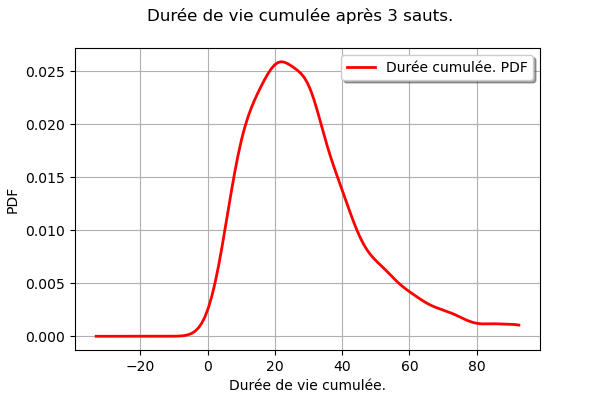

In [12]:
graph = ot.KernelSmoothing().build(outputSample).drawPDF()
graph.setTitle("Durée de vie cumulée après %d sauts." % (number_of_steps))
graph.setXTitle("Durée de vie cumulée.")
graph

## Comparaison avec la distribution exacte

La distribution de la durée de vie cumulée est une somme de 3 variables exponentielles. Elle suit la loi Gamma de paramètres $k=3$ et $\lambda$.

In [13]:
cumulated_life = (
    ot.Exponential(lambda_parameter)
    + ot.Exponential(lambda_parameter)
    + ot.Exponential(lambda_parameter)
)
print(cumulated_life)

Gamma(k = 3, lambda = 0.1, gamma = 0)


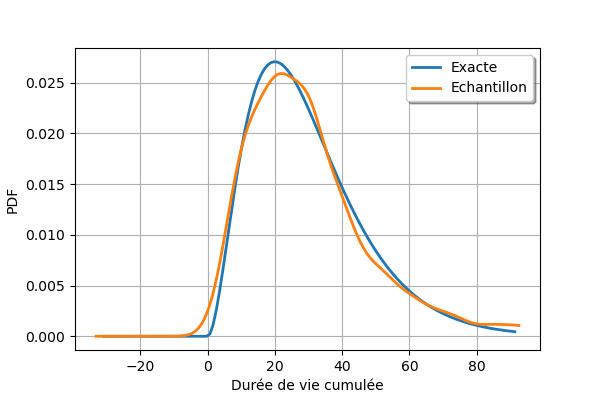

In [14]:
graph = cumulated_life.drawPDF()
graph.setLegends(["Exacte"])
curve = ot.KernelSmoothing().build(outputSample).drawPDF()
curve.setLegends(["Echantillon"])
graph.add(curve)
graph.setColors(ot.Drawable_BuildDefaultPalette(2))
graph.setXTitle("Durée de vie cumulée")
graph